In [0]:
import matplotlib.pyplot as plt
import numpy as np

"""# Neural Network Model"""

input_nodes     = 784
hidden1_nodes   = 196
hidden2_nodes   = 49
output_nodes    = 10
learning_rate   = 0.1
decay           = 0.8

def sigmoid(z):
  return 1 / ( 1 + np.exp(-z))

class NeuralNetwork:
  def __init__(self):
    self.lr = learning_rate
    self.decay = decay
    self.w1 = np.random.randn(input_nodes, hidden1_nodes)
    self.b1 = np.zeros((1, self.w1.shape[1]))  
    self.w2 = np.random.randn(self.w1.shape[1], hidden2_nodes)
    self.b2 = np.zeros((1, self.w2.shape[1]))  
    self.w3 = np.random.randn(self.w2.shape[1], output_nodes)
    self.b3 = np.zeros((1, self.w3.shape[1]))
    self.n  = ((self.w1.shape[0] * self.w1.shape[1]) + 
               (self.w2.shape[0] * self.w2.shape[1]) + 
               (self.w3.shape[0] * self.w3.shape[1]))

  def feedforward(self):
    z1 = np.dot(self.x, self.w1) + self.b1
    self.a1 = sigmoid(z1)
    z2 = np.dot(self.a1, self.w2) + self.b2
    self.a2 = sigmoid(z2)
    z3 = np.dot(self.a2, self.w3) + self.b3
    self.a3 = sigmoid(z3)      

  # def compute_cost(self, y_pred, y):
  #   m = y.shape[1]    
  #   cost = np.mean(np.sum(-y*np.log(y_pred), axis=1))
  #   return cost
  
  def compute_cost(self, l, h, m):
    J = np.sum(np.multiply(-l, np.log(h)) - np.multiply((1-h), np.log(1-h))) / m
    J += (self.decay / (2*self.n)) * ((np.sum(np.square(self.w1))) + 
                                      (np.sum(np.square(self.w2))) + 
                                      (np.sum(np.square(self.w3))))
    return J

  def backprop(self):        
    output_errors = self.y - self.a3        
    a3_delta = output_errors * (self.a3 * (1.0 - self.a3))       
    z2_delta = np.dot(output_errors, self.w3.T)
    a2_delta = z2_delta * (self.a2 * (1.0 - self.a2))       
    z1_delta = np.dot(z2_delta, self.w2.T)
    a1_delta = z1_delta * (self.a1 * (1.0 - self.a1))

    self.w3 += (self.lr * np.dot(self.a2.T, a3_delta) + 
                ((self.decay / self.n) * self.w3))
    self.b3 += self.lr * np.sum(a3_delta, axis=0, keepdims=True)       

    self.w2 += (self.lr * np.dot(self.a1.T, a2_delta) + 
                ((self.decay / self.n) * self.w2))
    self.b2 += self.lr * np.sum(a2_delta, axis=0, keepdims=True)  

    self.w1 += (self.lr * np.dot(self.x.T, a1_delta) + 
                ((self.decay / self.n) * self.w1))
    self.b1 += self.lr * np.sum(a1_delta, axis=0, keepdims=True)    
    
  def train(self, x, y):
    self.x = np.array(x, ndmin=2)
    self.y = np.array(y, ndmin=2)
    self.feedforward()
    self.backprop()

  def predict(self, data):
    self.x = np.array(data, ndmin=2)
    self.feedforward()
    return self.a3

  def evaluate(self, x, y):
    corrects, wrongs = 0, 0
    for i in range(len(x)):
      res = self.predict(x[i])
      res_max = res.argmax()
      if res_max == y[i]:
        corrects += 1        
      else:
        wrongs += 1        
    return corrects, wrongs

"""# Input Data"""

file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

#
# make a matrix each column of which represents an images in a vector form 
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

# parameters for get ave images
label_counter = np.zeros(10)
vector        = np.zeros((10, size_row * size_col))

for line in data:
  line_data             = line.split(',')
  label                 = line_data[0]
  im_vector             = np.asfarray(line_data[1:])    
  list_label[count]     = label
  list_image[:, count]  = im_vector
  count += 1

  label_counter[int(label)]  += 1
  vector[int(label)]         += im_vector


# Devide testing and training sets
train_size  = 1000
test_size   = 9000
fac         = 0.99 / 255

NN                = NeuralNetwork()
epochs            = 20
costs_train       = []
costs_test        = []
accuracys_train   = []
accuracys_test    = []


train_imgs = np.empty((train_size, size_row * size_col), dtype=float)
test_imgs = np.empty((test_size, size_row * size_col), dtype=float)
train_labels = np.empty(train_size, dtype=int)
test_labels = np.empty(test_size, dtype=int)
for i in range(num_image):
  if i < train_size:
    train_labels[i] = list_label[i]
    train_imgs[i]   = list_image[:, i]
  else:
    test_labels[i-train_size] = list_label[i]
    test_imgs[i-train_size]   = list_image[:, i]

train_imgs    = np.asfarray(train_imgs) * fac + 0.01
test_imgs     = np.asfarray(test_imgs) * fac + 0.01
train_labels  = np.asfarray(train_labels)
test_labels    = np.asfarray(test_labels)

train_targets         = np.array(train_labels).astype(np.int)
train_labels_one_hot  = np.eye(np.max(train_targets) + 1)[train_targets]
test_targets          = np.array(test_labels).astype(np.int)
test_labels_one_hot   = np.eye(np.max(test_targets) + 1)[test_targets]

train_labels_one_hot[train_labels_one_hot==0] = 0.01
train_labels_one_hot[train_labels_one_hot==1] = 0.99
test_labels_one_hot[test_labels_one_hot==0]   = 0.01
test_labels_one_hot[test_labels_one_hot==1]   = 0.99

for epoch in range(epochs):  
  for i in range(len(train_imgs)):
    NN.train(train_imgs[i], train_labels_one_hot[i])  
  
  corrects, wrongs = NN.evaluate(train_imgs, train_labels)  
  accuracys_train.append(corrects / ( corrects + wrongs))
  costs_train.append(NN.compute_cost(train_labels_one_hot, 
                                     NN.predict(train_imgs), 
                                     train_size))  

  corrects, wrongs = NN.evaluate(test_imgs, test_labels)  
  accuracys_test.append(corrects / ( corrects + wrongs))
  costs_test.append(NN.compute_cost(test_labels_one_hot, 
                                    NN.predict(test_imgs), 
                                    test_size))

# Get correct and wrong classified testing images
test_correct = []
img_correct = []
test_wrong = []
img_wrong = []
for i in range(len(test_imgs)):
  res = NN.predict(test_imgs[i])
  res_max = res.argmax()
  if res_max == test_labels[i]:
    test_correct.append(res_max)
    img_correct.append(i)
  else:
    test_wrong.append(res_max)
    img_wrong.append(i)

**Plot the loss curve**

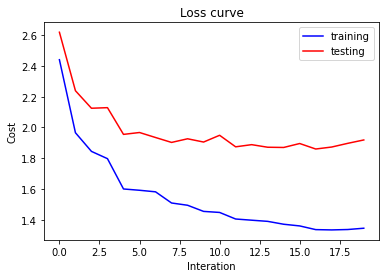

In [3]:
# Plot the loss curve
plt.title('Loss curve')
plt.plot(costs_train, c='b', label='training')
plt.plot(costs_test, c='r', label='testing')
plt.xlabel("Interation")
plt.ylabel("Cost")
plt.legend(loc='best')
plt.show()

**Plot the accuracy curve**

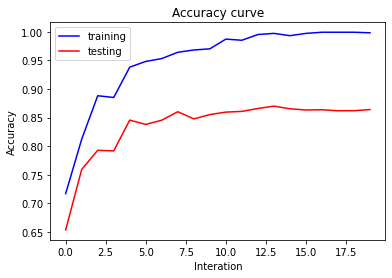

In [4]:
# Plot the accuracy curve
plt.title('Accuracy curve')
plt.plot(accuracys_train, c='b', label='training')
plt.plot(accuracys_test, c='r', label='testing')
plt.xlabel("Interation")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

**Plot final accuracy**


In [5]:
# Print final accuracy
print('Final training accuracy\t: ', 
      round(accuracys_train[epochs-1]*100, 2), '%')
print('Final testing accuracy\t: ', 
      round(accuracys_test[epochs-1]*100, 2), '%')

Final training accuracy	:  99.8 %
Final testing accuracy	:  86.39 %


**Plot the classification example**

10 correctly classified testing images with their labels at the title
--------------------------------------------------------------------------------
10 correctly classified testing images


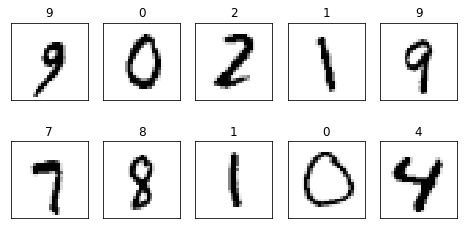


10 misclassified testing images with their misclassified labels at the title
--------------------------------------------------------------------------------


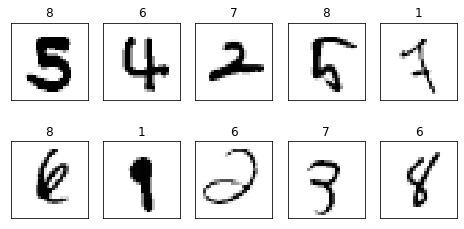

In [6]:
print('10 correctly classified testing images with their labels at the title')
print('-'*80)
print('10 correctly classified testing images')
fig = plt.figure(figsize=(8, 4))
for i in range(10):
  label = test_correct[i]
  plt.subplot(2, 5, i+1)  
  plt.title(label)
  plt.imshow(test_imgs[img_correct[i]].reshape((size_row, size_col)), 
             cmap='Greys', interpolation='None')
  frame   = plt.gca()
  frame.axes.get_xaxis().set_visible(False)
  frame.axes.get_yaxis().set_visible(False)
plt.show()
print('')
print('10 misclassified testing images with their misclassified labels at the title')
print('-'*80)
fig = plt.figure(figsize=(8, 4))
for i in range(10):  
  label = test_wrong[i]
  plt.subplot(2, 5, i+1)  
  plt.title(label)
  plt.imshow(test_imgs[img_wrong[i]].reshape((size_row, size_col)), 
             cmap='Greys', interpolation='None')
  frame   = plt.gca()
  frame.axes.get_xaxis().set_visible(False)
  frame.axes.get_yaxis().set_visible(False)
plt.show()